In [1]:
import findspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
spark = SparkSession.builder.appName('PM2.5 Chengdu').getOrCreate()

In [2]:
# Read from the data source
df = spark.read.csv('PMDataSets/ChengduPM20100101_20151231.csv',header=True,inferSchema=True)

In [ ]:
df.printSchema()

In [ ]:
df.describe().toPandas()

In [ ]:
df.select('PM_US Post').describe().show()

In [3]:
# Data Cleaning: Features Selection.
df_1 = df.drop('No','year','month','day','hour','season','PM_Caotangsi','PM_Shahepu')
# Data Cleaning: Remove instances with 'NA' value.
df_2 = df_1.filter(df['PM_US Post']!='NA')
df_3 = df_2.filter(df['DEWP']!='NA')
df_4 = df_3.filter(df['HUMI']!='NA')
df_5 = df_4.filter(df['PRES']!='NA')
df_6 = df_5.filter(df['TEMP']!='NA')
df_7 = df_6.filter(df['cbwd']!='NA')
df_8 = df_7.filter(df['Iws']!='NA')
df_9 = df_8.filter(df['precipitation']!='NA')
df_10 = df_9.filter(df['Iprec']!='NA')
df = df_10

In [ ]:
# This step shows the inconsistency of the data type.
df.printSchema()
df.describe().toPandas()

In [4]:
# Data Cleaning: Manually changing the data type.
df = df.withColumn('PM_US Post', df['PM_US Post'].cast("double"))
df = df.withColumn('DEWP', df['DEWP'].cast("double"))
df = df.withColumn('HUMI', df['HUMI'].cast("double"))
df = df.withColumn('PRES', df['PRES'].cast("double"))
df = df.withColumn('TEMP', df['TEMP'].cast("double"))
df = df.withColumn('Iws', df['Iws'].cast("double"))
df = df.withColumn('precipitation', df['precipitation'].cast("double"))
df = df.withColumn('Iprec', df['Iprec'].cast("double"))
df.printSchema()
df.describe().toPandas()

root
 |-- PM_US Post: double (nullable = true)
 |-- DEWP: double (nullable = true)
 |-- HUMI: double (nullable = true)
 |-- PRES: double (nullable = true)
 |-- TEMP: double (nullable = true)
 |-- cbwd: string (nullable = true)
 |-- Iws: double (nullable = true)
 |-- precipitation: double (nullable = true)
 |-- Iprec: double (nullable = true)



,summary,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,count,27368,27368,27368,27368,27368,27368,27368,27368,27368
1,mean,84.65649663840982,12.541837182110495,72.67594672610252,1014.7507453960808,18.129384682841273,None,4.268488745980707,0.10951110786319636,0.6431416252557738
2,stddev,57.96439993830218,7.501145687639762,18.294862653368636,8.056158682932704,7.730839566145991,None,6.311783149178579,1.0267246778451828,5.744616753930891
3,min,1.0,-16.0,12.78,991.0,-2.0,NE,0.0,0.0,0.0
4,max,688.0,28.0,100.0,1041.0,38.0,cv,93.0,51.7,169.4


In [5]:
# Data Cleaning: New feature construction
def judgement(x):
    if (x>=0) & (x<75):
        return 0
    elif (x>=75) & (x<150):
        return 1
    else:
        return 2
udf_judgement = udf(judgement, IntegerType())
df = df.withColumn('Harm',udf_judgement(df['PM_US Post']))
# Changing cbwd to numeric expression
def cbwd_vc(x):
    if x=='cv':
        return 0
    elif x=='SW':
        return 1
    elif x=='SE':
        return 2
    elif x=='NE':
        return 3
    else:
        return 4
udf_cbwd_vc = udf(cbwd_vc, IntegerType())
df = df.withColumn('cbwd',udf_cbwd_vc(df['cbwd']))
df.describe().toPandas()

,summary,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec,Harm
0,count,27368,27368,27368,27368,27368,27368,27368,27368,27368,27368
1,mean,84.65649663840982,12.541837182110495,72.67594672610252,1014.7507453960808,18.129384682841273,1.3440149079216603,4.268488745980707,0.10951110786319636,0.6431416252557738,0.5812262496346098
2,stddev,57.96439993830218,7.501145687639762,18.294862653368636,8.056158682932704,7.730839566145991,1.5730364458436414,6.311783149178579,1.0267246778451828,5.744616753930891,0.7025428719320684
3,min,1.0,-16.0,12.78,991.0,-2.0,0,0.0,0.0,0.0,0
4,max,688.0,28.0,100.0,1041.0,38.0,4,93.0,51.7,169.4,2


In [6]:
# Data Transformation: Further reduction
df = df.drop('PM_US Post')
# Data Transformation: Correlation Check
print("DEWP-Harm Correlation:",df.corr('DEWP','Harm'))
print("HUMI-Harm Correlation:",df.corr('HUMI','Harm'))
print("PRES-Harm Correlation:",df.corr('PRES','Harm'))
print("TEMP-Harm Correlation:",df.corr('TEMP','Harm'))
print("cbwd-Harm Correlation:",df.corr('cbwd','Harm'))
print("Iws-Harm Correlation:",df.corr('Iws','Harm'))
print("Precipitation-Harm Correlation:",df.corr('precipitation','Harm'))
print("Iprec-Harm Correlation:",df.corr('Iprec','Harm'))

DEWP-Harm Correlation: -0.31110652944135114
HUMI-Harm Correlation: 0.12418612984200451
PRES-Harm Correlation: 0.2474606627230661
TEMP-Harm Correlation: -0.3910476876569656
cbwd-Harm Correlation: -0.11255946423870748
Iws-Harm Correlation: -0.1812214832304343
Precipitation-Harm Correlation: -0.06596618921797352
Iprec-Harm Correlation: -0.08343551109766166


In [7]:
# Data Transformation: Further reduction according to correlation
df = df.drop('precipitation','Iprec')
df.toPandas()

,DEWP,HUMI,PRES,TEMP,cbwd,Iws,Harm
0,4.0,24.24,1013.9,26.0,0,2.0,0
1,18.0,88.28,1008.1,20.0,0,4.0,0
2,19.0,88.37,1004.1,21.0,0,4.0,1
3,20.0,83.25,1003.1,23.0,0,4.0,1
4,18.0,73.50,1003.1,23.0,3,2.0,0
5,18.0,69.20,1003.1,24.0,3,4.0,1
6,19.0,78.24,1004.1,23.0,3,7.0,1
7,18.0,73.50,1004.1,23.0,3,9.0,0
8,18.0,78.09,1005.1,22.0,3,12.0,1
9,18.0,78.09,1006.1,22.0,0,2.0,1


In [ ]:
# Changing to pandas dataframe for Data Balancing: OverSampling
df_pandas = df.toPandas()
print(df_pandas['Harm'].value_counts())
df_0 = df_pandas[df_pandas['Harm'] == 0]
df_1 = df_pandas[df_pandas['Harm'] == 1]
df_2 = df_pandas[df_pandas['Harm'] == 2]
df_1_new = df_1.sample(frac=1.64,replace=True)
df_2_new = df_2.sample(frac=4.3, replace=True)
df_pandas = pd.concat([df_0, df_1_new, df_2_new], ignore_index=True)
df_pandas.sample(frac=1)
print(df_pandas['Harm'].value_counts())
df = spark.createDataFrame(df_pandas)
df.toPandas()

In [8]:
# Preparing for machine learning
cbwd_Indexer = StringIndexer(inputCol = 'cbwd', outputCol = 'cbwdIndex')
cbwd_encoder = OneHotEncoder(inputCol = 'cbwdIndex', outputCol = 'cbwdVec')

Harm_Indexer = StringIndexer(inputCol = 'Harm', outputCol = 'label')

assembler = VectorAssembler(inputCols=['DEWP','HUMI','PRES','cbwdVec','TEMP','Iws'], outputCol="features")

In [9]:
# Pipeline
pipeline = Pipeline(stages=[cbwd_Indexer, Harm_Indexer, cbwd_encoder, assembler])
pipeline_model = pipeline.fit(df)
pipe_df = pipeline_model.transform(df)
pipe_df = pipe_df.select('label', 'features')
pipe_df.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)



In [ ]:
# Decision Tree Classifier
from pyspark.ml.classification import DecisionTreeClassifier
train_data, test_data = pipe_df.randomSplit([0.8,0.2])
print("Training Dataset Count: " + str(train_data.count()))
print("Test Dataset Count: " + str(test_data.count()))
dt = DecisionTreeClassifier(featuresCol='features',labelCol='label')
dt_model = dt.fit(train_data)
predictions = dt_model.transform(test_data)
predictions.select("prediction", "label", "features").show(5)

In [10]:
# Randomforest Classifier
from pyspark.ml.classification import RandomForestClassifier
train_data, test_data = pipe_df.randomSplit([0.8,0.2])
print("Training Dataset Count: " + str(train_data.count()))
print("Test Dataset Count: " + str(test_data.count()))
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label',numTrees=30,  maxDepth = 6)
rf_Model = rf.fit(train_data)
predictions = rf_Model.transform(test_data)
predictions.select("prediction", "label", "features").show(5)

Training Dataset Count: 22011
Test Dataset Count: 5357
+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       1.0|  0.0|(9,[0,1,2,3],[-5....|
|       1.0|  0.0|(9,[1,2,3,7],[65....|
|       1.0|  0.0|(9,[1,2,3,7],[65....|
|       0.0|  0.0|[-16.0,20.14,1034...|
|       0.0|  0.0|[-15.0,21.89,1033...|
+----------+-----+--------------------+
only showing top 5 rows



In [ ]:
# Evaluating Accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g" % (accuracy))

In [ ]:
rf_Model.featureImportances

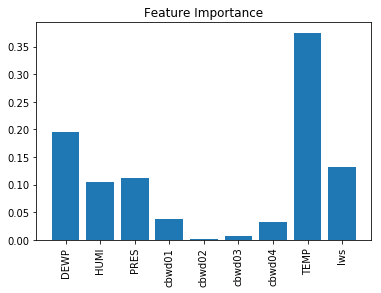

In [11]:
importances = rf_Model.featureImportances
plt.bar(['DEWP','HUMI','PRES','cbwd01','cbwd02','cbwd03','cbwd04','TEMP','Iws'],importances)
plt.title("Feature Importance")
plt.xticks(rotation=90)
plt.show()

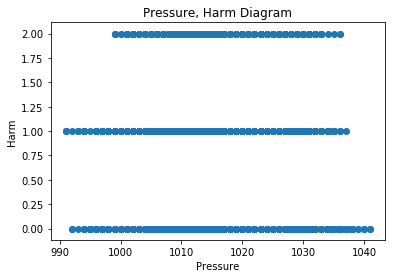

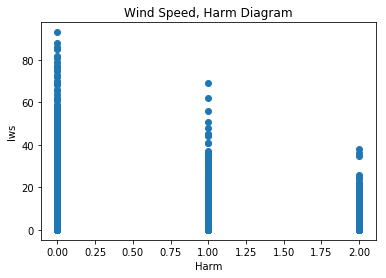

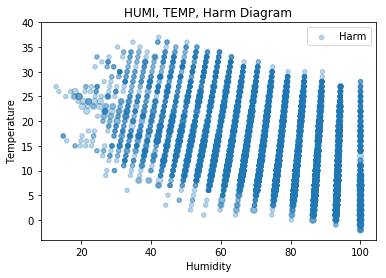

In [13]:
df_pandas = df.toPandas()

plt.scatter(df_pandas['PRES'],df_pandas['Harm'])
plt.title("Pressure, Harm Diagram")
plt.xlabel("Pressure")
plt.ylabel("Harm")
plt.show()

plt.scatter(df_pandas['Harm'],df_pandas['Iws'])
plt.title("Wind Speed, Harm Diagram")
plt.xlabel("Harm")
plt.ylabel("Iws")
plt.show()

plt.scatter(df_pandas['HUMI'],df_pandas['TEMP'],df_pandas['Harm']*20, alpha=0.3)
plt.title("HUMI, TEMP, Harm Diagram")
plt.xlabel("Humidity")
plt.ylabel("Temperature")
plt.legend(["Harm"])
plt.show()